# Bayesian Structural Time-series Model


In [6]:
import pandas as pd 
import numpy as np 
import pymc3 as pm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [14]:
data = pd.read_csv("./daily-temp.csv")

data["train"] = data["Date"].map(lambda x: x < "1989" )
data.head(5)

Date  Temp  train
0  1981-01-01  20.7   True
1  1981-01-02  17.9   True
2  1981-01-03  18.8   True
3  1981-01-04  14.6   True
4  1981-01-05  15.8   True

In [21]:
# using plotly.express API, not low-level graph_objects
fig = px.scatter(data_frame=data,
    x="Date",
    y="Temp",
    color="train",
    ) # using plotly.express API
fig.update_traces(marker=dict(size=4))
fig.show()

In [23]:
# using plotly.express API, not low-level graph_objects
fig = px.scatter(data_frame=data[data["Date"]<"1983"],
    x="Date",
    y="Temp",
    color="train",
    ) # using plotly.express API
fig.update_traces(marker=dict(size=4))
fig.show()

>Structural time-series models are state-space models for time-series data

Consider the pairs of equations $$ \begin{align} y_t & = Z_t^T \alpha_t + \epsilon_t , \\ \alpha_{t+1} & = T_t \alpha_t + R_t \eta_t \end{align} $$ where $$ \epsilon_t \sim \mathcal{N}\left(0,\sigma_t^2\right) $$ and $$ \eta_t \sim \mathcal{N}\left(0,Q_t\right) $$ 

The equation for $y_t$ is the *observation equation*, since it links observations $y$ to latent-space state variaable $\alpha$. The second equation is the *state equation*, which describes the evolution of the state over time.

$Z_t$ is an output vector, $T_t$ is a transition matrix, $R_t$ is a control matrix, $\epsilon_t$ is a scalar observation error, and $\eta_t$ is a system error. 

>Writing the error structure of equation (2.2) as $R_t\eta_t$ allows us to incorporate state components of less than full rank.



Structural time-series models are
* flexible: a very large class of models, including all ARIMA models.
* modular: the latent state and the model matrices can be assembled from sub-models to capture important features (e.g., seasonality, holidays).

We are able to choose appropriate components to capture the features we want.


### Component 1: local linear trend

$$ \begin{align} \mu_{t+1} & = \mu_t + \delta_t + \eta_{\mu,t}, \\ \delta_{t+1} & = \delta_t + \eta_{\delta,t} \end{align} $$ where the $\eta$s are both normally distributed with mean-zero and their own covariances. Note that $\delta_t$ represents the expected increase in $\mu$ between times $t$ and $t+1$, so it plays the role of a slope.

This component "quickly adapts to local variation," which is useful for short-term predictions.

### Component 2: seasonality

One frequent time-domain, state-component seasonality model is $$ \gamma_{t+1} = -\sum_{s=0}^{S-2} \gamma_{t-s} + \eta_{\gamma, t} $$ Here $S$ is number of seasons, and $\gamma_t$ is their joint contribution to the observed response $y_t$. The state is the $S-1$ most recent seasonal effects. The error term is scalar, so the evol equation is less than full rank.

In Bayesian approach, we specify prior distributions $p\left(\theta\right)$ on all parameters $\theta$, as well as a distribution $p\left(\alpha_0 | \theta\right)$ on the initial state values. We then obtain the posterior distribution by sample from $ p\left(\alpha,\theta | y\right)$ in the usual way: MCMC.

In [2]:
data = pd.read_csv("./daily-temp.csv")

data["train"] = data["Date"].map(lambda x: x < "1989" )
data["Date"] = pd.to_datetime(data["Date"])
data["y_scaled"] = data["Temp"] / data["Temp"].max() # scale observations
data['t'] = (data["Date"] - data["Date"].min()) / (data["Date"].max() - data["Date"].min())

data.head(5)

# data.plot(x="t", y='y_scaled')

Date  Temp  train  y_scaled         t
0 1981-01-01  20.7   True  0.787072  0.000000
1 1981-01-02  17.9   True  0.680608  0.000274
2 1981-01-03  18.8   True  0.714829  0.000548
3 1981-01-04  14.6   True  0.555133  0.000822
4 1981-01-05  15.8   True  0.600760  0.001096

In [3]:
def det_dot(a,b):
    return (a*b[None,:]).sum(axis=-1)


def trend_model(m, t, n_cp = 25, cp_prior_scale=0.05, growth_prior_scale=5, cp_range=0.8):
    """
        Piecewise linear trend with change-point.

        :param m: (pm.Model)
        :param t: (np.array) scaled time

        :return g, A, s: (tt.vector, np.array, tt.vector)
    """

    s = np.linspace(0, cp_range*np.max(t), n_cp + 1)[1:]

    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k',0, growth_prior_scale)

        if cp_prior_scale is None:
            cp_prior_scale = pm.Exponential('tau', 1.5)

        # rate of change
        delta = pm.Laplace('delta', 0, cp_prior_scale, shape=n_cp)

        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta

        g = (k + det_dot(A,delta))*t + (m+det_dot(A,gamma))
    return g, A, s

        

In [5]:
m = pm.Model()
with m:
    y, A, s = trend_model(m, data['t'])

    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)

    pm.Normal('obs',mu=y, sd=sigma, observed=data["y_scaled"])

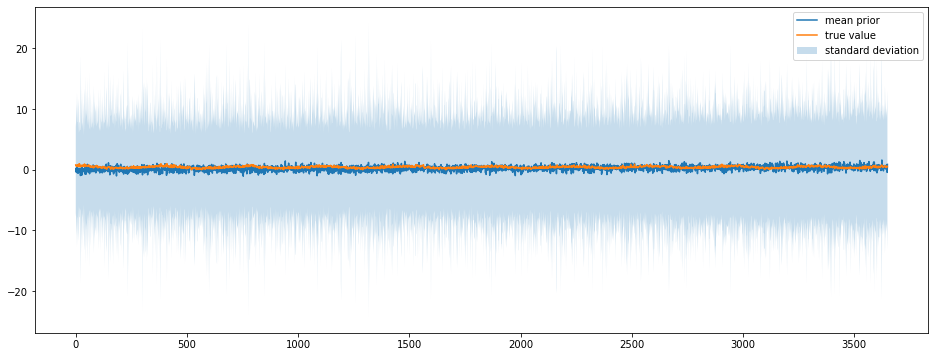

In [8]:
def sanity_check(m, df):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(model=m, vars=['obs'])['obs']
    plt.figure(figsize=(16, 6))
    plt.plot(y.mean(0), label='mean prior')
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    plt.plot(df['y_scaled'], label='true value')
    plt.legend()

# And run the sanity check
sanity_check(m, data)

In [11]:
def fourier_series(t, p=365.25, n=10):
    x = 2 * np.pi * np.arange(1, n+1) / p
    x = x * t[:,None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

def seasonality_model(m, df, period='yearly', seasonality_prior_scale=10):

    if period == 'yearly':
        n = 10
        p = 365.25 / (df["Date"].max() - df["Date"].min()).days
    else:
        n = 3
        p = 7 / (df["Date"].max() - df["Date"].min()).days

    x = fourier_series(df["t"], p, n)

    with m:
        beta = pm.Normal(f"beta_{period}",
        mu = 0,
        sd=seasonality_prior_scale,
        shape=2*n)
    return x, beta

In [13]:
m = pm.Model() 

with m:
    y, A, s = trend_model(m, data["t"], cp_prior_scale=None)
    x_yearly, beta_yearly = seasonality_model(m, data, 'yearly')
    x_weekly, beta_weekly = seasonality_model(m, data, 'weekly')

    y += det_dot(x_yearly, beta_yearly) + det_dot(x_weekly, beta_weekly)

    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    obs = pm.Normal('obs',
        mu=y,
        sd=sigma,observed=data["y_scaled"])

In [14]:
with m:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_weekly, beta_yearly, m, delta, tau, k]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 3156 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'k'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'delta'}>],
       [<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'beta_yearly'}>,
        <AxesSubplot:title={'center':'beta_yearly'}>],
       [<AxesSubplot:title={'center':'beta_weekly'}>,
        <AxesSubplot:title={'center':'beta_weekly'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

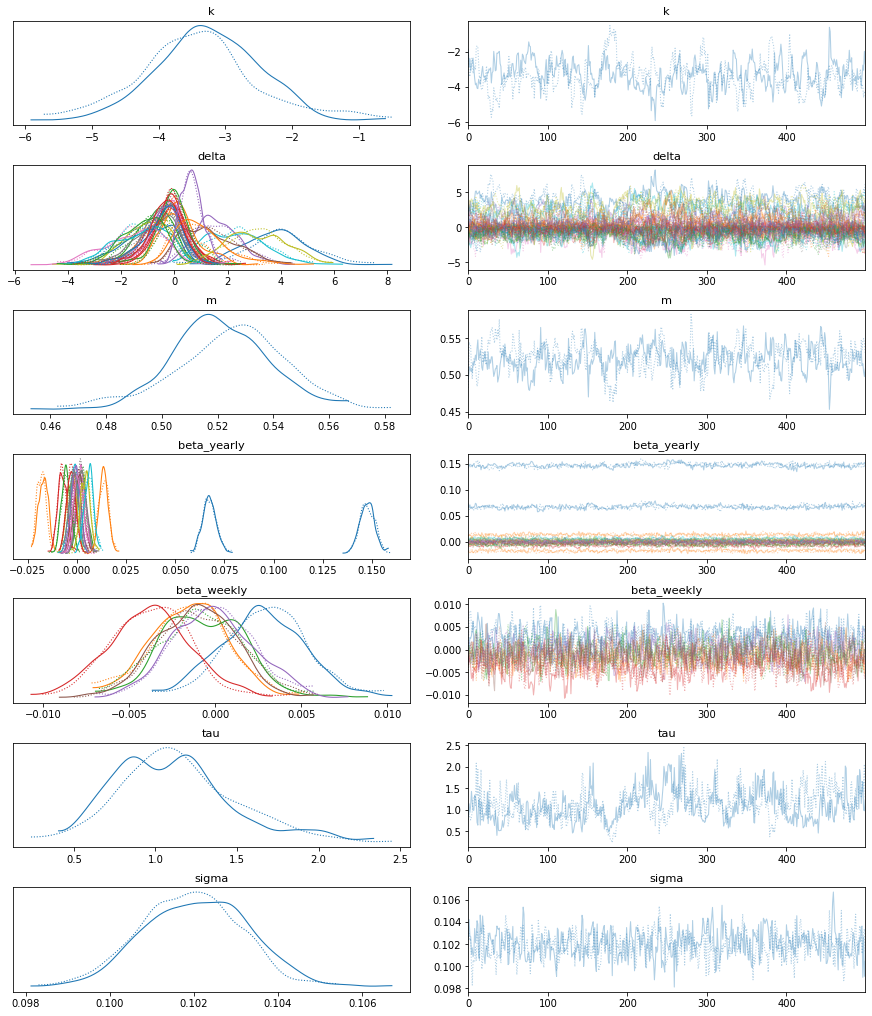

In [15]:
pm.traceplot(trace)

In [17]:
import pickle

with open('model.pkl','wb') as fout:
    pickle.dump((m,trace), file=fout)

In [18]:
trace

<MultiTrace: 2 chains, 500 iterations, 9 variables>

In [24]:
def det_seasonality_posterior(beta, x):
    return np.dot(x,beta.T)

p=0.025
# vector distributions
beta_yearly = trace["beta_yearly"]
beta_weekly = trace["beta_weekly"]
delta = trace["delta"]

# scalar distributions
k = trace["k"]
m = trace["m"]

# determine the posterior
trend_posterior = ((k + np.dot(A, delta.T)) * data["t"][:,None] + m + np.dot(A, (-s*delta).T)) * data["Temp"].max()
yearly_posterior = det_seasonality_posterior(beta_yearly, x_yearly) * data['Temp'].max()
weekly_posterior = det_seasonality_posterior(beta_weekly, x_weekly) * data['Temp'].max()

date = data['Date'].dt.to_pydatetime()
sunday = np.argmax(data['Date'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(data['Date'].dt.dayofyear)

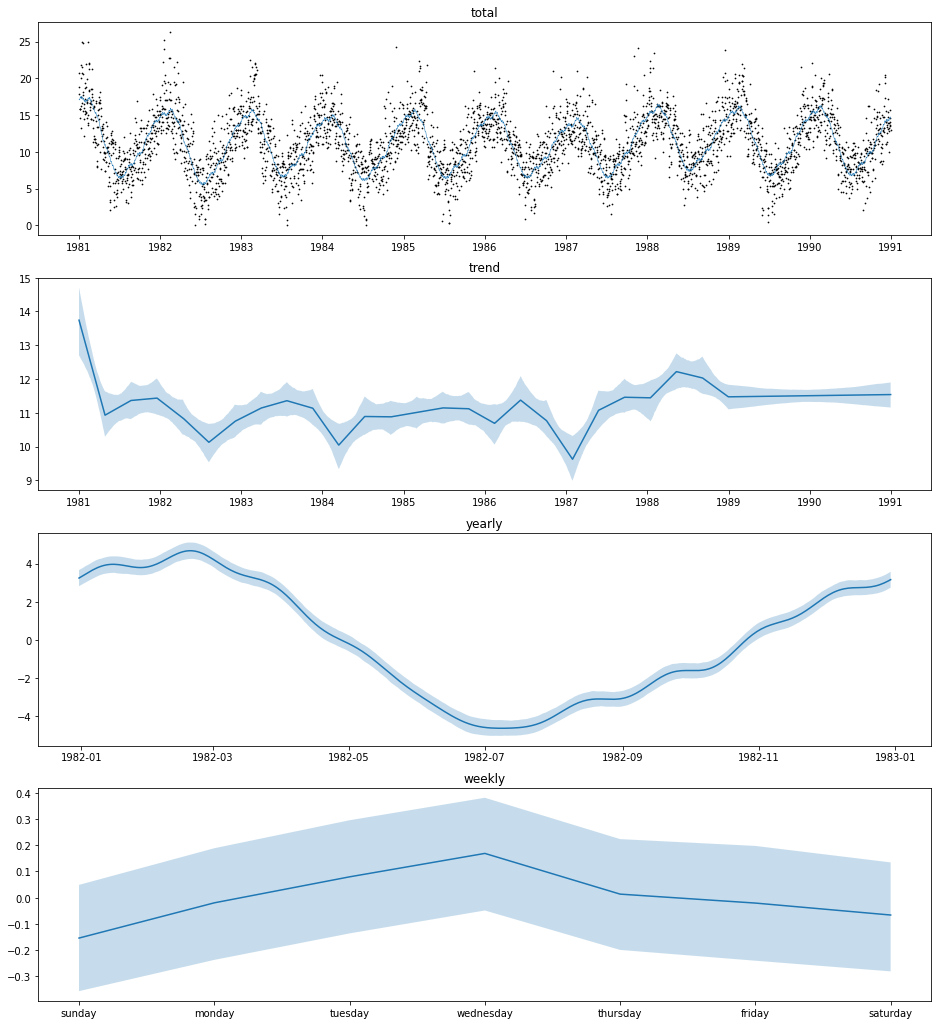

In [25]:
plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date,
         (trend_posterior + yearly_posterior + weekly_posterior).mean(1), lw=0.5)
plt.scatter(date, data['Temp'], s=0.5, color='black')

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], yearly_posterior.mean(1)[idx_year: idx_year + 365])
quant = np.quantile(yearly_posterior, [p, 1 - p], axis=1)
plt.fill_between(date[idx_year: idx_year + 365],
                 quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekdays, weekly_posterior.mean(1)[sunday: sunday + 7])
quant = np.quantile(weekly_posterior, [p, 1 - p], axis=1)
plt.fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)

https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/

https://en.wikipedia.org/wiki/Bayesian_structural_time_series
